In [466]:
#Defining necessary constants
# Import NumPy for array handling
#
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from radmc3dPy import *
import subprocess as p

#
# A simple grid refinement function
#
def grid_refine_inner_edge(x_orig,nlev,nspan):
    x     = x_orig.copy()
    rev   = x[0]>x[1]
    for ilev in range(nlev):
        x_new = 0.5 * ( x[1:nspan+1] + x[:nspan] )
        x_ref = np.hstack((x,x_new))
        x_ref.sort()
        x     = x_ref
        if rev:
            x = x[::-1]
    return x
#
# Some natural constants
#
au  = 1.49598e13     # Astronomical Unit       [cm]
pc  = 3.08572e18     # Parsec                  [cm]
ms  = 1.98892e33     # Solar mass              [g]
ts  = 5.78e3         # Solar temperature       [K]
ls  = 3.8525e33      # Solar luminosity        [erg/s]
rs  = 6.96e10        # Solar radius            [cm]
ss  = 5.6703e-5      # Stefan-Boltzmann const  [erg/cm^2/K^4/s]
kk  = 1.3807e-16     # Bolzmann's constant     [erg/K]
mp  = 1.6726e-24     # Mass of proton          [g]
GG  = 6.67408e-08    # Gravitational constant  [cm^3/g/s^2]
pi  = np.pi          # Pi

#
# Star parameters
#
mstar    = ms
rstar    = rs
tstar    = ts
pstar    = np.array([0.,0.,0.])

#
# First make a simple analytical disk model roughly along the
# lines of Chiang & Goldreich (1997), but with just a single
# vertical layer and with a constant radiative incidence angle.
#
flang    = 0.05      # The assumed constant radiative incidence angle
nr       = 500        # Nr of radial grid points
rin      = 1*au     # Inner radius
rout     = 260*au    # Outer radius
nlev_rin = 12        # Grid refinement at the inner edge: nr of cycles
nspan_rin= 3         # Grid refinement at the inner edge: nr of cells each cycle
ri       = np.logspace(np.log10(rin),np.log10(rout),nr+1)
#ri       = grid_refine_inner_edge(ri,nlev_rin,nspan_rin)   # Refinement at inner edge
rc       = 0.5 * ( ri[:-1] + ri[1:] )
nr       = len(rc)   # Recompute nr, because of refinement at inner edge
r        = rc        # The radial grid of the analytic disk model
lstar    = 4*pi*rstar**2*ss*tstar**4   # Stellar luminosity
firr     = flang*lstar/(4*pi*r**2)     # Irradiative flux
tmid     = (firr/ss)**0.25             # Estimate of midplane temperature
cs       = np.sqrt(kk*tmid/(2.3*mp))   # Isothermal sound speed at midplane
omk      = np.sqrt(GG*mstar/r**3)      # The Kepler angular frequency     
hp       = cs/omk                      # The pressure scale height
hpr      = hp/r                        # The dimensionless hp

#
# Vertical grid parameters (theta-grid in spherical coordinates)
#
ntheta   = 100
zrmax    = 0.5
thetaup  = np.pi*0.5 - 0.5e0

#
# Make the theta and phi coordinates
#
nphi     = 10
thetai   = np.linspace(thetaup,0.5e0*np.pi,ntheta+1)
phii     = np.linspace(0.e0,np.pi*2.e0,nphi+1)
thetac   = 0.5 * ( thetai[0:ntheta] + thetai[1:ntheta+1] )
phic     = 0.5 * ( phii[0:nphi] + phii[1:nphi+1] )

#
# Make the 2-D grid (actually 3-D but with axisymmetry)
#
qq       = np.meshgrid(rc,thetac,phic,indexing='ij')
rr       = qq[0]
tt       = qq[1]
zr       = np.pi/2.e0 - qq[1]

# Monte Carlo parameters
#
nphot    = 1000000

#
# Write the wavelength_micron.inp file
#
lam1     = 0.1e0
lam2     = 7.0e0
lam3     = 25.e0
lam4     = 1.0e4
n12      = 20
n23      = 100
n34      = 30
lam12    = np.logspace(np.log10(lam1),np.log10(lam2),n12,endpoint=False)
lam23    = np.logspace(np.log10(lam2),np.log10(lam3),n23,endpoint=False)
lam34    = np.logspace(np.log10(lam3),np.log10(lam4),n34,endpoint=True)
lam      = np.concatenate([lam12,lam23,lam34])
nlam     = lam.size
    


1036
[2.01710499e+04 2.01710842e+04 2.01711185e+04 ... 1.97609761e+01
 1.97884663e+01 1.98712435e+01]


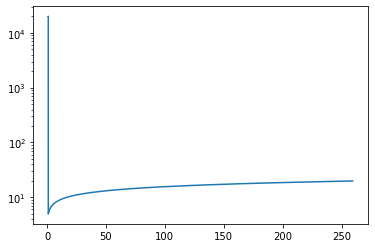

In [207]:
print(nr)
print(hp / np.gradient(r))
plt.semilogy(r / au, hp / np.gradient(r))
plt.show()

In [467]:
#Defining a Function for Input Files
def rad_setup(radius, amplitude, location):
    #
    # Disk parameters
    #
    sigmag0  = 1700               # Sigma gas at 1 AU [g/cm^2]
    sigmad0  = sigmag0 * 0.01    # Sigma dust at 1 AU
    plsig    = -1.0e0            # Powerlaw of the surface density
    sigmad   = (sigmad0 * (r/au)**plsig)*np.exp(-(r/(60*au)))   # The surface density profile

    def pert(radius, amplitude, location):
        value = amplitude*np.exp(-((radius-location)/hp)**2)
        return value

    sigmad *= (1 + pert(radius, amplitude, location)) #Addition of a perturbation

    #
    # Expand the 1-D analytic model to 2-D
    #
    sigmad_3d  = np.meshgrid(sigmad,thetac,phic,indexing='ij')[0]
    hh         = np.meshgrid(hp,thetac,phic,indexing='ij')[0]
    hhr        = np.meshgrid(hpr,thetac,phic,indexing='ij')[0]

    #
    # Make the dust density model
    #
    rhod     = sigmad_3d / (np.sqrt(2.e0*np.pi)*hh) * np.exp(-((zr**2/hhr**2)/2.e0))

    #
    # Write the wavelength file
    #
    with open('wavelength_micron.inp','w+') as f:
        f.write('%d\n'%(nlam))
        for value in lam:
            f.write('%13.6e\n'%(value))
    #
    #
    # Write the stars.inp file
    #
    with open('stars.inp','w+') as f:
        f.write('2\n')
        f.write('1 %d\n\n'%(nlam))
        f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n'%(rstar,mstar,pstar[0],pstar[1],pstar[2]))
        for value in lam:
            f.write('%13.6e\n'%(value))
        f.write('\n%13.6e\n'%(-tstar))
    #
    # Write the grid file
    #
    with open('amr_grid.inp','w+') as f:
        f.write('1\n')                       # iformat
        f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
        f.write('100\n')                     # Coordinate system: spherical
        f.write('0\n')                       # gridinfo
        f.write('1 1 1\n')                   # Include r,theta coordinates
        f.write('%d %d %d\n'%(nr,ntheta,nphi))  # Size of grid
        for value in ri:
            f.write('%13.6e\n'%(value))      # X coordinates (cell walls)
        for value in thetai:
            f.write('%13.6e\n'%(value))      # Y coordinates (cell walls)
        for value in phii:
            f.write('%13.6e\n'%(value))      # Z coordinates (cell walls)
    #
    # Write the density file
    #
    with open('dust_density.inp','w+') as f:
        f.write('1\n')                       # Format number
        f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
        f.write('1\n')                       # Nr of dust species
        data = rhod.ravel(order='F')         # Create a 1-D view, fortran-style indexing
        data.tofile(f, sep='\n', format="%13.6e")
        f.write('\n')
    #
    # Dust opacity control file
    #
    with open('dustopac.inp','w+') as f:
        f.write('2               Format number of this file\n')
        f.write('1               Nr of dust species\n')
        f.write('============================================================================\n')
        f.write('1               Way in which this dust species is read\n')
        f.write('0               0=Thermal grain\n')
        f.write('silicate        Extension of name of dustkappa_***.inp file\n')
        f.write('----------------------------------------------------------------------------\n')
    #
    # Write the radmc3d.inp control file
    #
    with open('radmc3d.inp','w+') as f:
        f.write('nphot = %d\n'%(nphot))
        f.write('scattering_mode_max = 1\n')
        f.write('iranfreqmode = 1\n')
        f.write('modified_random_walk = 1')
        
    return sigmad



In [379]:
from IPython.display import clear_output
def pert_param_search(amp_initial, amp_final, loc_initial, loc_final, a_step, l_step):
    #Compute the noise level
    rad_setup(r, 0, 1)
    p.run(['radmc3d', 'mctherm', 'setthreads', '6'])
    data = analyze.readData(dtemp = True)
    data.readDustTemp()
    NoPertTemp = np.average(np.array(data.dusttemp[:,:,:,0].T), axis = 0)
    clear_output()
    
    #Define relevant lists
    sigmad_list = [[[] for j in range(0, int((amp_final - amp_initial) / a_step))] for i in range(0, int((loc_final - loc_initial) / l_step))] 
    temp_list = [[[] for j in range(0, int((amp_final - amp_initial) / a_step))] for i in range(0, int((loc_final - loc_initial) / l_step))]
    for i in range(0, int((loc_final - loc_initial) / l_step)):
        for j in range(0, int((amp_final - amp_initial) / a_step)):
            sigmad = rad_setup(r, j*a_step + amp_initial, i*l_step + loc_initial) #Write the input files
            p.run(['radmc3d', 'mctherm', 'setthreads', '6']) #Run radmc3d to create output files
            sigmad_list[i][j] = np.array(sigmad)
            data = analyze.readData(dtemp = True)
            data.readDustTemp()
            temp_list[i][j] = np.average(np.array(data.dusttemp[:,:,:,0].T), axis = 0)
            clear_output()
        
    
    return sigmad_list, temp_list, NoPertTemp, data;

sigmad_list, temp_list, NoPertTemp, data = pert_param_search(3, 11, 25*au, 275*au, 2, 50*au)

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

KeyboardInterrupt: 

In [468]:
#Creating 3D Relative Temperature Plots
from matplotlib.pyplot import cm
from scipy import ndimage
amp_initial, amp_final, loc_initial, loc_final, a_step, l_step = 3, 11, 25*au, 275*au, 2, 50*au
for i in range(0, int((loc_final - loc_initial) / l_step)):
    for j in range(0, int((amp_final - amp_initial) / a_step)):

        x = data.grid.x/natconst.au
        l = i*l_step + loc_initial
        #The index of X which corresponds to the value in X closest to the location of the perturbation
        l_index = np.abs(x - (l / au)).argmin()
        width = hp[l_index]
        
        fig = plt.figure(figsize = (10,10))
        ax = plt.axes(projection='3d')
        ax.set_title('Relative Temperature (A = '+str(j*a_step + amp_initial)+', L = '+str((i*l_step + loc_initial)/au)+' Au, W = '+str(width / au)+' Au)')
        ax.set_xlabel('Distance [Au]')
        ax.set_ylabel('Angle from Midplane [Radians]')
        ax.set_zlabel('Percent Change in Temperature')
        ax.set_zlim(-15, 15)

        X, Y = np.meshgrid(x, np.pi/2. - data.grid.y)
        #Z = sp.ndimage.filters.gaussian_filter(np.transpose(np.transpose(temp_list[i][j])[AU_to_index:]), 1.25)
        Z = sp.ndimage.filters.gaussian_filter((100*(temp_list[i][j] - NoPertTemp) / NoPertTemp), 2)
        ax.plot_surface(X, Y, Z, vmin = -15, vmax = 15, rcount = 100, ccount = 100, edgecolor = 'none', cmap = cm.coolwarm)
        plt.show()
                

AttributeError: module 'radmc3dPy.data' has no attribute 'grid'

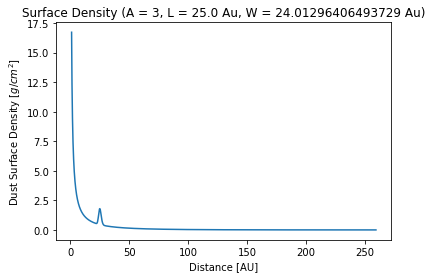

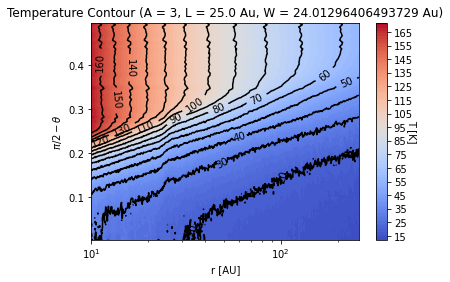

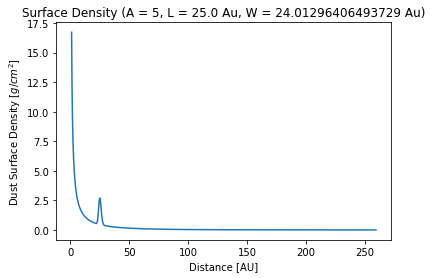

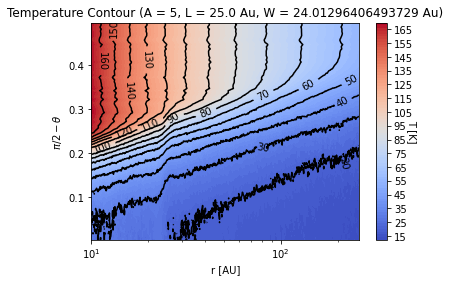

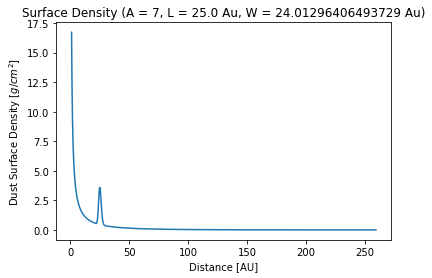

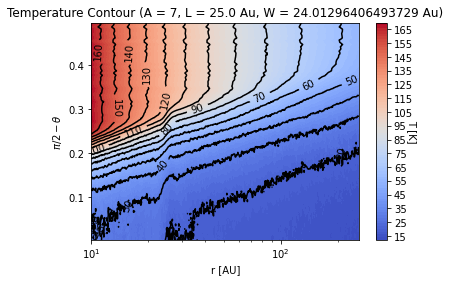

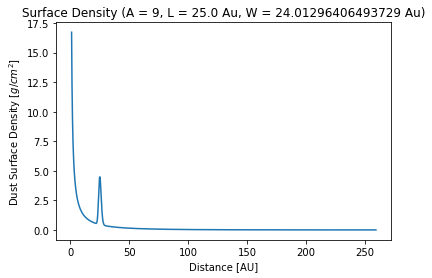

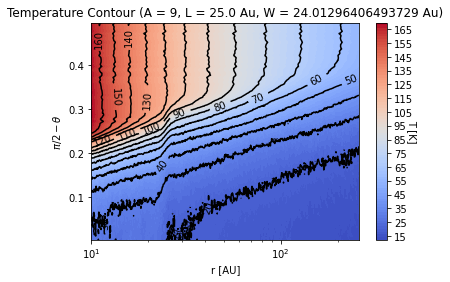

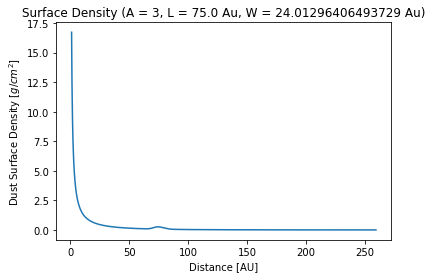

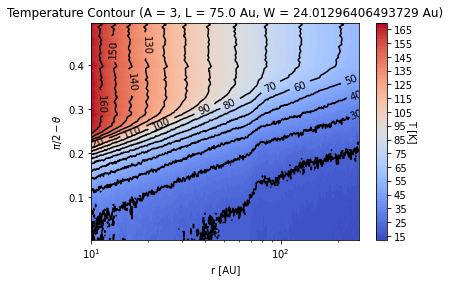

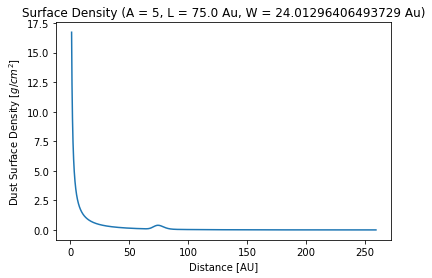

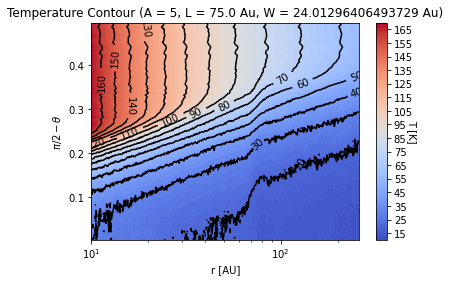

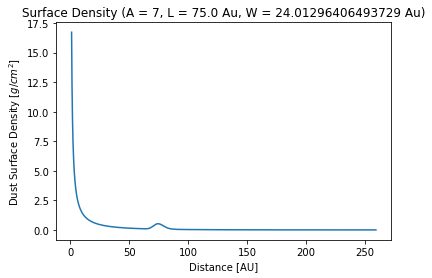

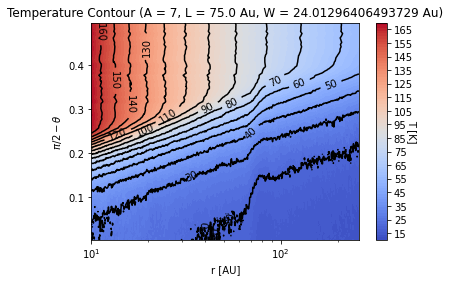

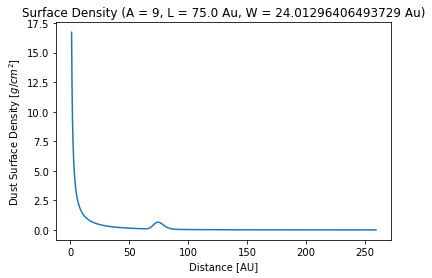

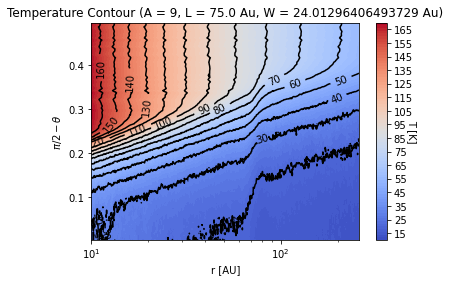

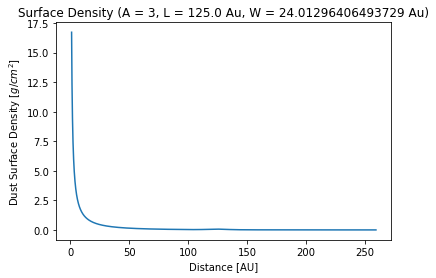

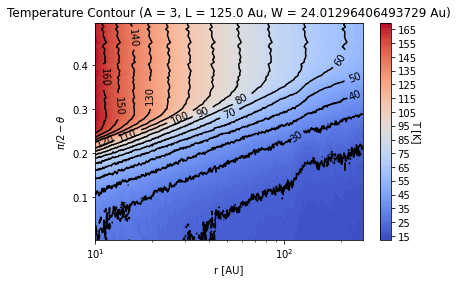

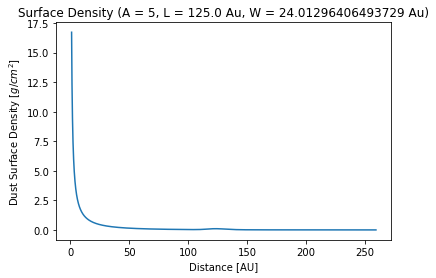

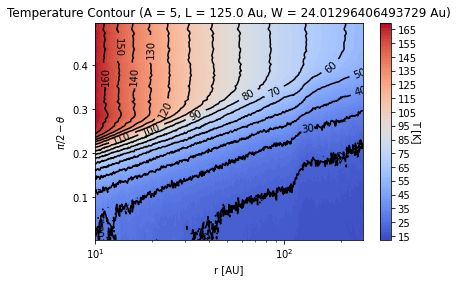

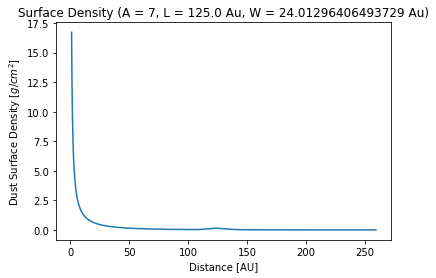

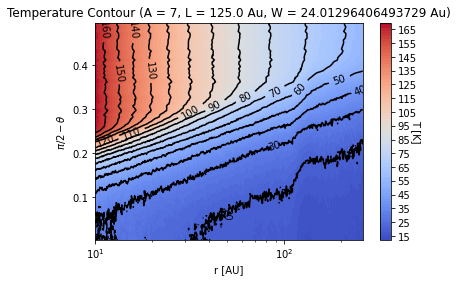

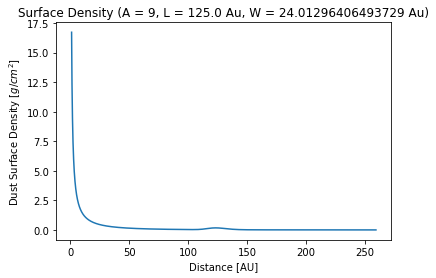

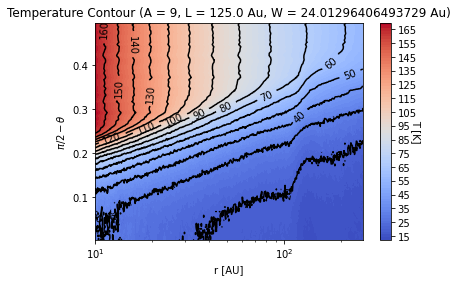

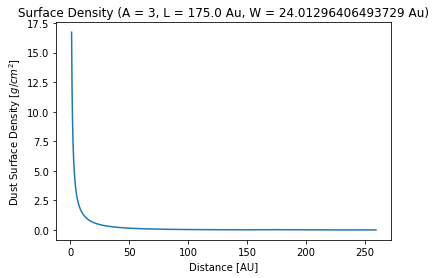

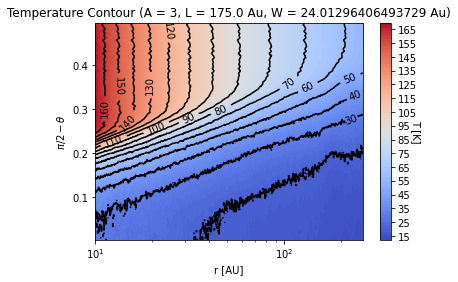

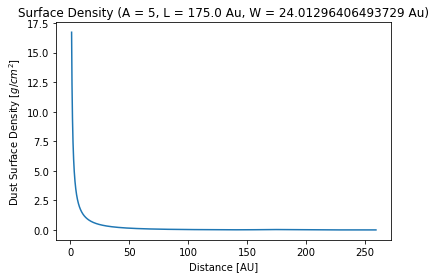

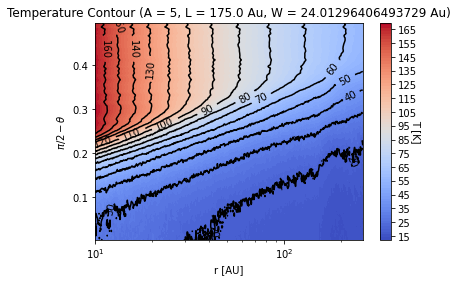

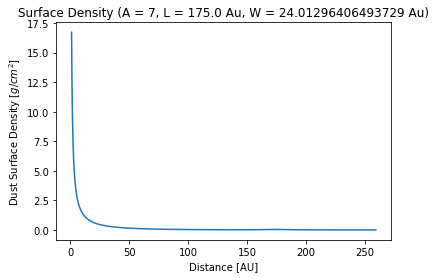

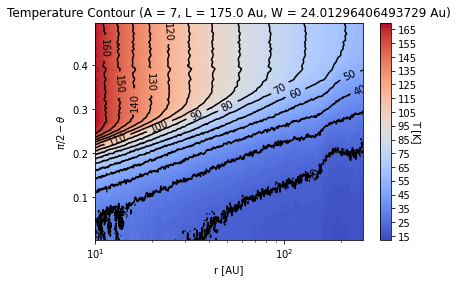

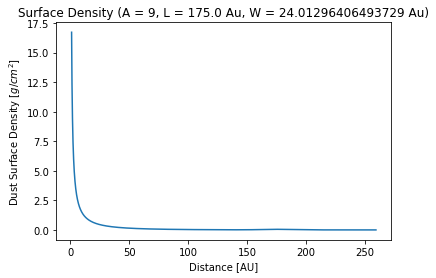

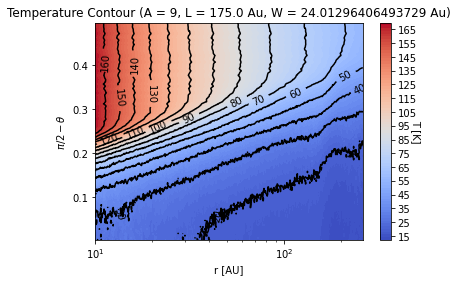

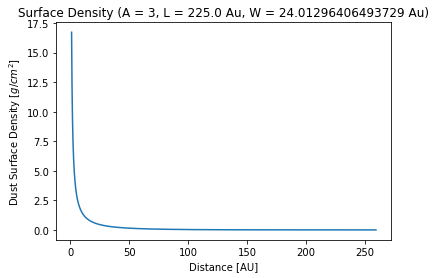

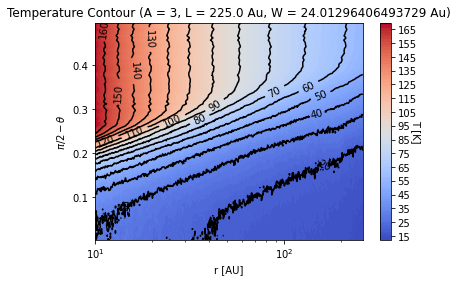

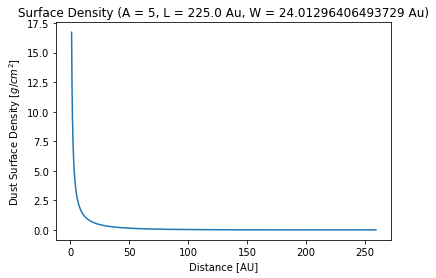

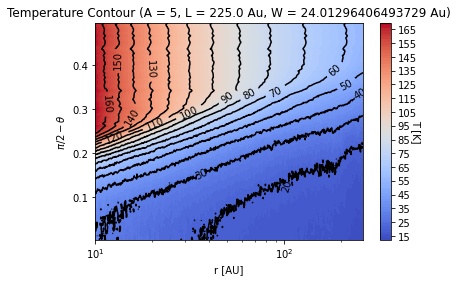

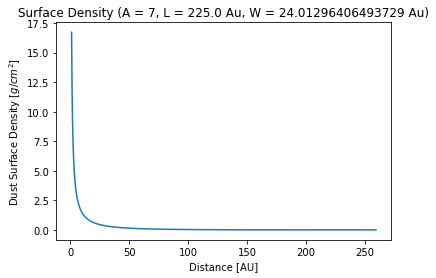

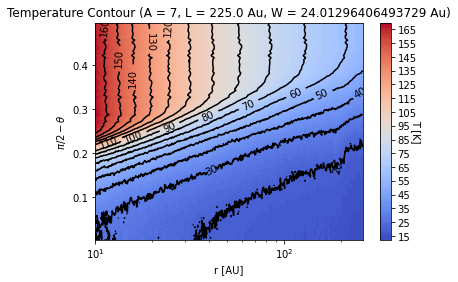

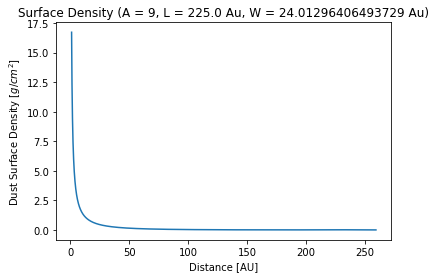

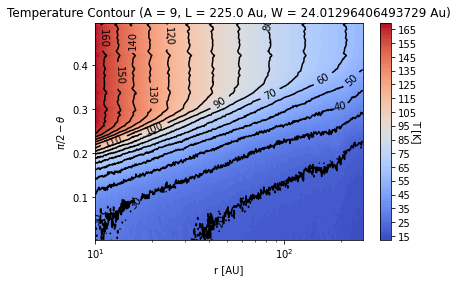

In [399]:
#Creating Surface Density and Temperature Contour Plots
from matplotlib.pyplot import cm
from scipy import ndimage
amp_initial, amp_final, loc_initial, loc_final, a_step, l_step = 3, 11, 25*au, 275*au, 2, 50*au
for i in range(0, int((loc_final - loc_initial) / l_step)):
    for j in range(0, int((amp_final - amp_initial) / a_step)):
        x = data.grid.x/natconst.au
        l = i*l_step + loc_initial
        #The index of X which corresponds to the value in X closest to 10 AU
        AU_to_index = np.abs(x - 10).argmin()
        
        plt.plot(x, sigmad_list[i][j])
        plt.title('Surface Density (A = '+str(j*a_step + amp_initial)+', L = '+str((i*l_step + loc_initial)/au)+' Au, W = '+str(hp[l_index] / au)+' Au)')
        plt.xlabel('Distance [AU]')
        plt.ylabel('Dust Surface Density [$g/cm^2$]')
        plt.show()

        fig, ax = plt.subplots()
        c = ax.contourf(x[AU_to_index:], np.pi/2.-data.grid.y, np.transpose(np.transpose(temp_list[i][j])[AU_to_index:]), 100, cmap = cm.coolwarm)
        ax.set_xlabel('r [AU]')
        ax.set_ylabel(r'$\pi/2-\theta$')
        ax.set_title('Temperature Contour (A = '+str(j*a_step + amp_initial)+', L = '+str((i*l_step + loc_initial)/au)+' Au, W = '+str(hp[l_index] / au)+' Au)')
        ax.set_xscale('log')
        ax.set_xlim(10, 260)
        Ticks = np.linspace(15, 185, 18)
        cb = plt.colorbar(c, ticks = Ticks)
        cb.set_label('T [K]', rotation=270.)

        c = ax.contour(x[AU_to_index:], np.pi/2.-data.grid.y, np.transpose(np.transpose(temp_list[i][j])[AU_to_index:]), 15,  colors='k', linestyles='solid')
        ax.clabel(c, inline=1, fontsize=10)
        plt.show()
            
#         x = data.grid.x/natconst.au
#         l = i*l_step + loc_initial
#         #The index of X which corresponds to the value in X closest to the location of the perturbation
#         l_index = np.abs(x - (l / au)).argmin()
#         width = hp[l_index]
#         #Create a loop to find an equally spaced interval on either side of the perturbation
#         for backward in range(1, l_index): 
#             if abs(x[l_index] - x[l_index - backward]) <= 3*width / au: 
#                 pass
#             else:
#                 B = backward
#                 break

#         for forward in range(1, len(X) - l_index):
#             if abs(x[l_index] - x[l_index + forward]) <= 3*width / au:
#                 pass
#             else:
#                 F = forward
#                 break


#         plt.plot(x[(l_index - B):(l_index + F)], np.average(temp_list[i][j], axis = 0)[(l_index - B):(l_index + F)])
#         plt.plot(x[(l_index - B):(l_index + F)], np.average(NoPertTemp, axis = 0)[(l_index - B):(l_index + F)])
#         plt.show()

#         fig, ax = plt.subplots()
#         ax.set_title('Relative Temperature (A = '+str(j*a_step + amp_initial)+', L = '+str((i*l_step + loc_initial)/au)+' Au, W = '+str(hp[l_index] / au)+' Au)')
#         ax.set_xlabel('Distance [Au]')
#         ax.set_ylabel('Percent Change in Temperature')
#         ax.plot(x[(l_index - B):(l_index + F)], 100*(np.average(temp_list[i][j], axis = 0)[(l_index - B):(l_index + F)] - np.average(NoPertTemp, axis = 0)[(l_index - B):(l_index + F)]) / np.average(NoPertTemp, axis = 0)[(l_index - B):(l_index + F)])
#         plt.show()

/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


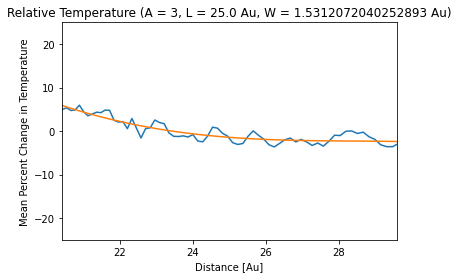

/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


Fit Equation:-0.000437R**4 + 0.0308R**3 + -0.513R**2 + -5.48R + 145.0
Maximum Value: 5.957329388243195
581
Minimum Value: -5.141716552855108


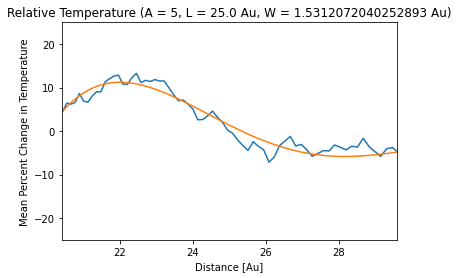

Fit Equation:-0.0185R**4 + 2.0R**3 + -80.5R**2 + 1420.0R + -9300.0
Maximum Value: 13.28219030522103
589
Minimum Value: -8.1208863433545


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


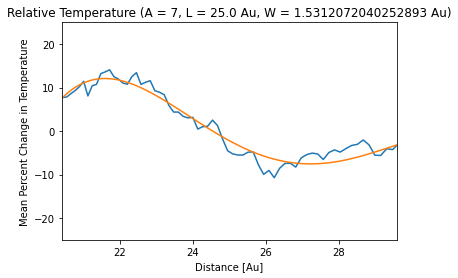

Fit Equation:-0.0248R**4 + 2.64R**3 + -104.0R**2 + 1810.0R + -11600.0
Maximum Value: 14.090778247823888
587
Minimum Value: -10.725286309277715


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


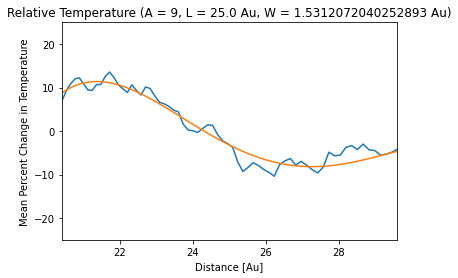

Fit Equation:-0.0217R**4 + 2.3R**3 + -90.6R**2 + 1560.0R + -9980.0
Maximum Value: 13.581689620623964
585
Minimum Value: -10.374130593584853


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


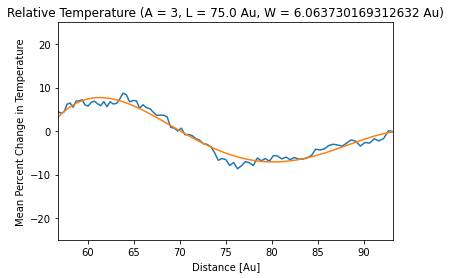

Fit Equation:-0.000139R**4 + 0.0437R**3 + -5.08R**2 + 258.0R + -4830.0
Maximum Value: 8.732308544533097
771
Minimum Value: -8.662712027044142


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


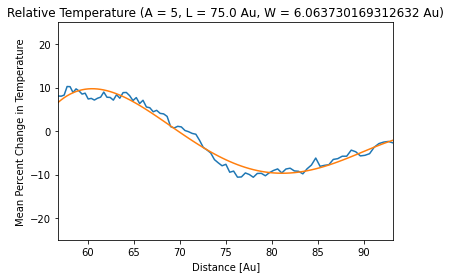

Fit Equation:-0.000128R**4 + 0.0408R**3 + -4.78R**2 + 244.0R + -4560.0
Maximum Value: 10.24666354834357
765
Minimum Value: -10.61767504441774


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


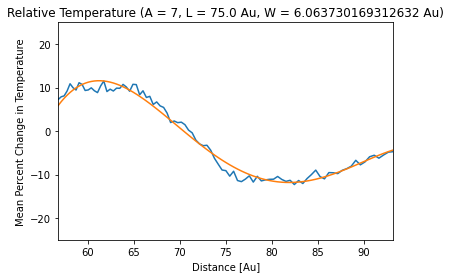

Fit Equation:-0.000162R**4 + 0.0517R**3 + -6.09R**2 + 313.0R + -5900.0
Maximum Value: 11.51282804407297
769
Minimum Value: -12.294295137845475


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


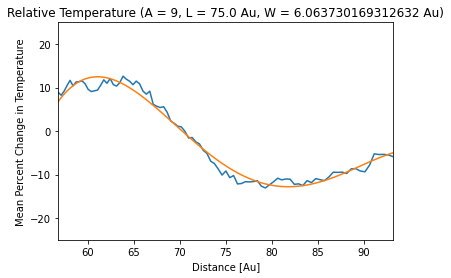

Fit Equation:-0.000175R**4 + 0.0558R**3 + -6.55R**2 + 336.0R + -6320.0
Maximum Value: 12.632509543793699
769
Minimum Value: -13.079018981546973


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


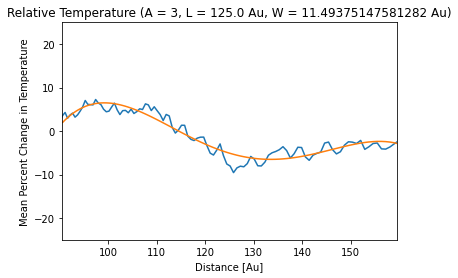

Fit Equation:-1.22e-05R**4 + 0.00632R**3 + -1.21R**2 + 101.0R + -3090.0
Maximum Value: 7.2619676561378546
852
Minimum Value: -9.554890713307453


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


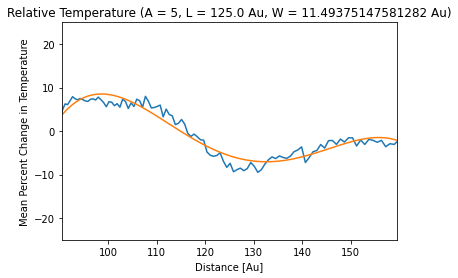

Fit Equation:-1.48e-05R**4 + 0.00766R**3 + -1.46R**2 + 121.0R + -3680.0
Maximum Value: 7.9888343586705295
851
Minimum Value: -9.484929290603892


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


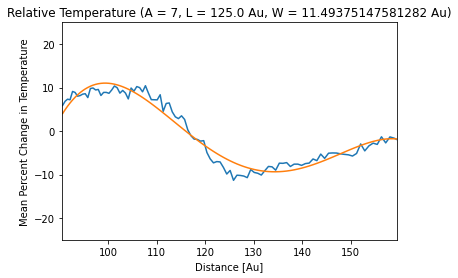

Fit Equation:-1.73e-05R**4 + 0.00902R**3 + -1.74R**2 + 146.0R + -4500.0
Maximum Value: 10.432888448586919
854
Minimum Value: -11.321670667383083


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


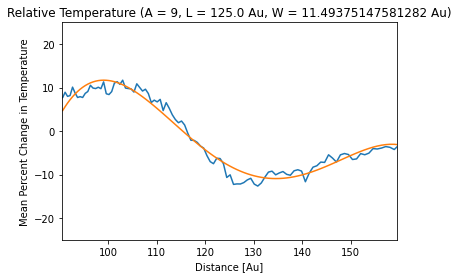

Fit Equation:-1.83e-05R**4 + 0.00955R**3 + -1.84R**2 + 154.0R + -4750.0
Maximum Value: 11.698465227055083
853
Minimum Value: -12.64366894375325


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


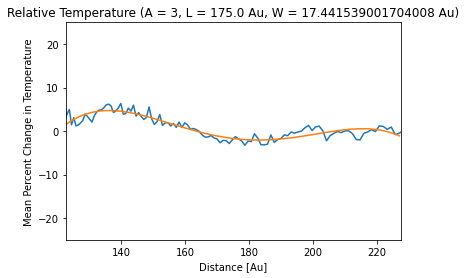

Fit Equation:-1.79e-06R**4 + 0.00127R**3 + -0.335R**2 + 38.4R + -1610.0
Maximum Value: 6.3478678343188095
907
Minimum Value: -3.264745471957335


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


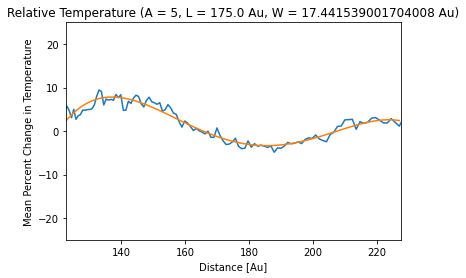

Fit Equation:-2.38e-06R**4 + 0.00173R**3 + -0.463R**2 + 54.0R + -2310.0
Maximum Value: 9.45546000918199
905
Minimum Value: -4.871748987562641


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


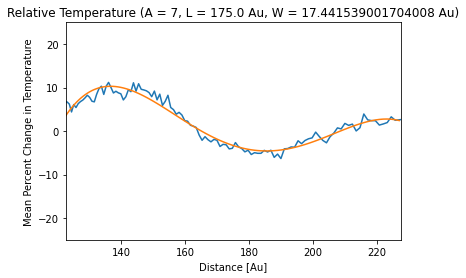

Fit Equation:-3.1e-06R**4 + 0.00225R**3 + -0.603R**2 + 70.1R + -2980.0
Maximum Value: 11.196226622375839
909
Minimum Value: -6.3222847677311576


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


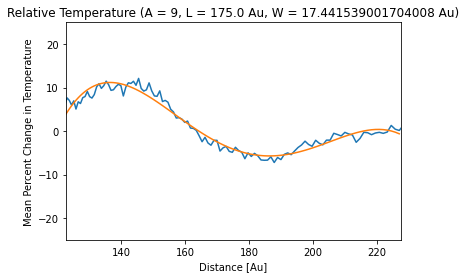

Fit Equation:-3.48e-06R**4 + 0.00252R**3 + -0.671R**2 + 77.9R + -3310.0
Maximum Value: 12.113644816641516
909
Minimum Value: -7.225970594972731


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


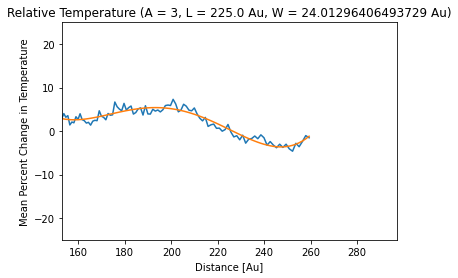

Fit Equation:1.38e-06R**4 + -0.0011R**3 + 0.325R**2 + -41.8R + 1990.0
Maximum Value: 7.300907018415789
945
Minimum Value: -4.628293518007688


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


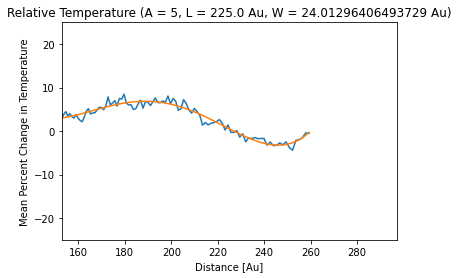

Fit Equation:1.17e-06R**4 + -0.00091R**3 + 0.26R**2 + -32.2R + 1480.0
Maximum Value: 8.489915522827411
949
Minimum Value: -4.406176235969971


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


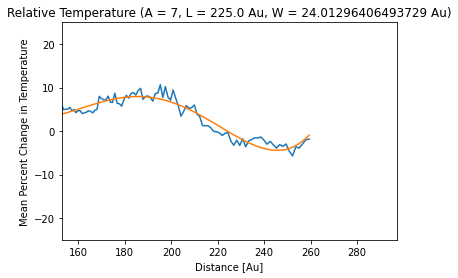

Fit Equation:1.2e-06R**4 + -0.000917R**3 + 0.257R**2 + -31.3R + 1410.0
Maximum Value: 10.665018346961256
948
Minimum Value: -5.702042954762028


/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: divide by zero encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
/tmp/ipykernel_18909/1200364302.py:48: RuntimeWarning: invalid value encountered in true_divide
  T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]


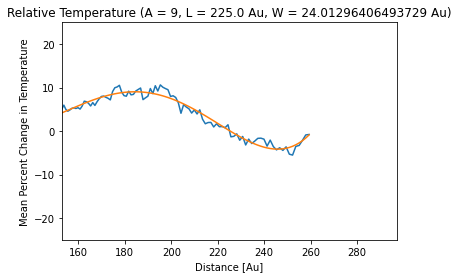

Fit Equation:1.06e-06R**4 + -0.000798R**3 + 0.219R**2 + -25.8R + 1120.0
Maximum Value: 10.618677990121627
951
Minimum Value: -5.519743837685404


In [459]:
#Mean Relative Temperature Plots and Curve-Fitting
from scipy.optimize import curve_fit
amp_initial, amp_final, loc_initial, loc_final, a_step, l_step = 3, 11, 25*au, 275*au, 2, 50*au
amp_arr = np.array([])
loc_arr = np.array([])
T_max = np.empty((int((loc_final - loc_initial) / l_step), int((amp_final - amp_initial) / a_step)))
T_max_index = np.empty((int((loc_final - loc_initial) / l_step), int((amp_final - amp_initial) / a_step)))
for i in range(0, int((loc_final - loc_initial) / l_step)):
    for j in range(0, int((amp_final - amp_initial) / a_step)):
        x = data.grid.x/natconst.au
        l = i*l_step + loc_initial
        a = j*a_step + amp_initial
        #Append only unique amplitude and location values 
        if a not in amp_arr:
            amp_arr = np.append(amp_arr, a)
        else:
            pass
        if l not in loc_arr:
            loc_arr = np.append(loc_arr, l)
        else: 
            pass
        #The index of x which corresponds to the value in x closest to the location of the perturbation
        l_index = np.abs(x - (l / au)).argmin()
        width = hp[l_index]
        #Create a loop to find an equally spaced interval on either side of the perturbation
        for backward in range(1, l_index): 
            if abs(x[l_index] - x[l_index - backward]) <= 3*width / au: 
                pass
            else:
                B = backward
                break

        for forward in range(1, len(X) - l_index):
            if abs(x[l_index] - x[l_index + forward]) <= 3*width / au:
                pass
            else:
                F = forward
                break
        
        fig, ax = plt.subplots()
        ax.set_title('Relative Temperature (A = '+str(j*a_step + amp_initial)+', L = '+str(l/au)+' Au, W = '+str(hp[l_index] / au)+' Au)')
        ax.set_xlabel('Distance [Au]')
        ax.set_ylabel('Mean Percent Change in Temperature')
        ax.set_ylim(-25, 25)
        #Calculate the mean percent change in temperature over the first 20 values in the angular direction
        T_for_mean = [[] for k in range(0, 19)]
        for k in range(-20,-1):
            T_for_mean[k + 20] = 100*(temp_list[i][j][k] - NoPertTemp[k]) / NoPertTemp[k]
        
        T_mean = sum(T_for_mean) / len(T_for_mean)
        
        ax.set_xlim((l - 3*width) / au, (l + 3*width) / au)
        ax.plot(x, T_mean)
        
        #Define a function form for curve-fitting
        def fit_form(dist, a, b, c, d, e):
            return a*dist**4 + b*dist**3 + c*dist**2 + d*dist + e
        
        #Focus on the data in the desired range
        xdata = x[(l_index - B):(l_index + F)] #Save
        ydata = T_mean[(l_index - B):(l_index + F)] #Save
        popt, pcov = curve_fit(fit_form, xdata, ydata)
        ax.plot(xdata, fit_form(xdata, *popt))
        plt.show()
        
        a, b, c, d, e = popt
        print('Fit Equation:'+str(round(a, 2-int(np.floor(np.log10(abs(a))))))+'R**4 + '+str(round(b, 2-int(np.floor(np.log10(abs(b))))))+'R**3 + '+str(round(c, 2-int(np.floor(np.log10(abs(c))))))+'R**2 + '+str(round(d, 2-int(np.floor(np.log10(abs(d))))))+'R + '+str(round(e, 2-int(np.floor(np.log10(abs(e)))))))
        
        #Find the maximum value in the desired range
        max_value = 0
        max_index = l_index - B
        for n in T_mean[(l_index - B):(l_index + F)]:
            if n > max_value:
                max_value = n
                max_index = max_index + 1
            else:
                pass
        print("Maximum Value: " +str(max_value))
        T_max[i][j] = max_value
        T_max_index[i][j] = max_index
        print(max_index)
        #Find the minimum value in the desired range
        min_value = 0
        for n in T_mean[(l_index - B):(l_index + F)]:
            if n < min_value:
                min_value = n
            else:
                pass
        print("Minimum Value: " +str(min_value))
        
#Look into built in python maxima functions
#Stats and signal processing library
#Look into interpolation and prob distributions (interpolate grid)
#Try to fit gaussians
#Looking forward: perturbation parameter search for difference dust populations / opacities
#Create surface density distributions for every dust population based on their mass contribution and repeat the temperature variation 
#fitting process
#dust scale height is .2 or .3 of the gas height
#Pkl tool = fast way of saving everything in dictionary to a file
#Pickle module can read them
#Before 11 or after 4

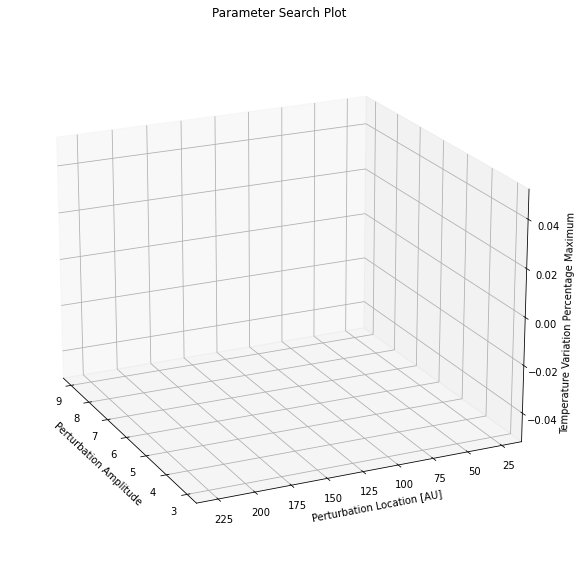

In [464]:
#Plot maximum temperature variation percentage as a function of radius and amplitude
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_title('Parameter Search Plot')
ax.set_xlabel('Perturbation Amplitude')
ax.set_ylabel('Perturbation Location [AU]')
ax.set_zlabel('Temperature Variation Percentage Maximum')

X, Y = np.meshgrid(amp_arr, loc_arr / au)
Z = T_max
ax.plot_surface(X, Y, Z, rcount = 100, ccount = 100, edgecolor = 'none', cmap = cm.coolwarm)
ax.view_init(20,155)
plt.show()

In [465]:
print(T_max)

[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


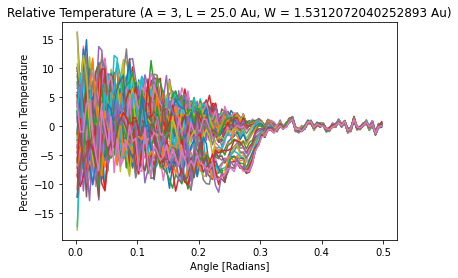

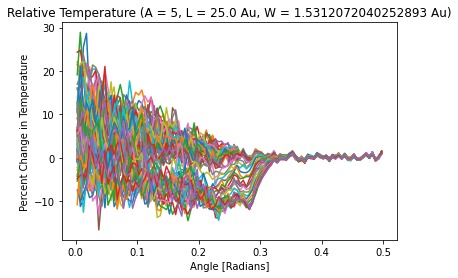

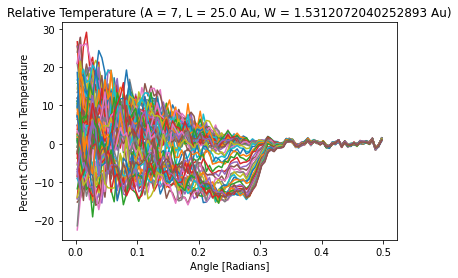

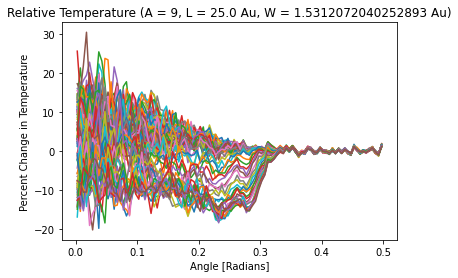

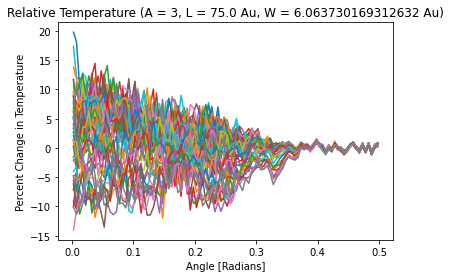

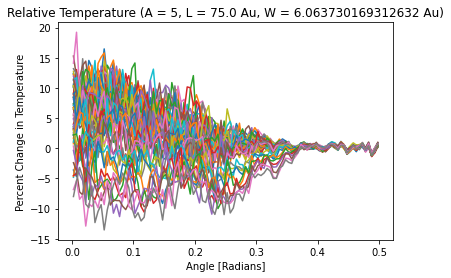

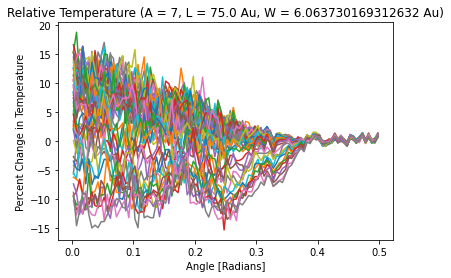

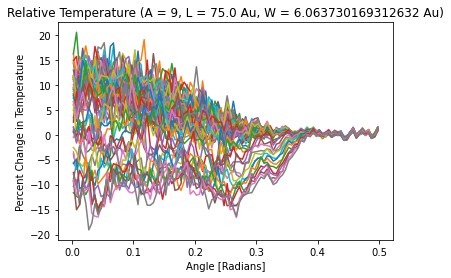

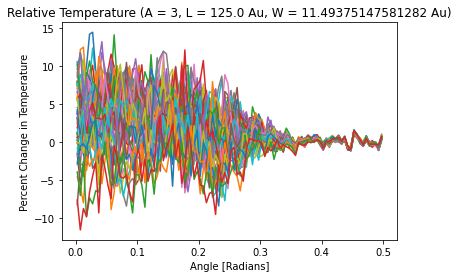

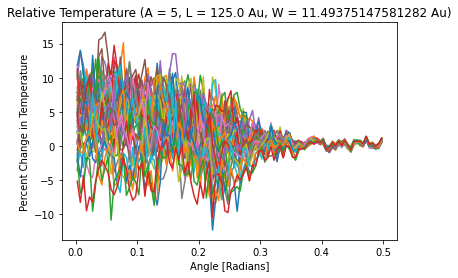

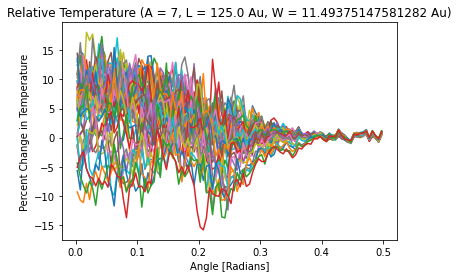

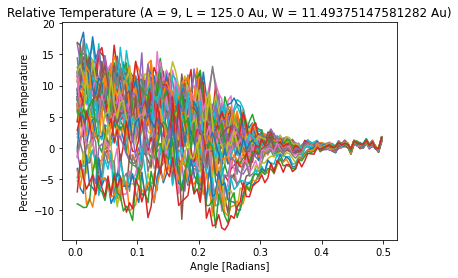

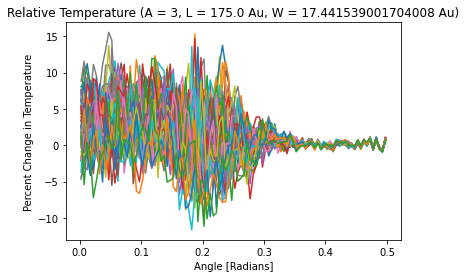

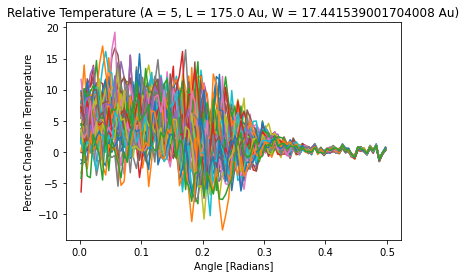

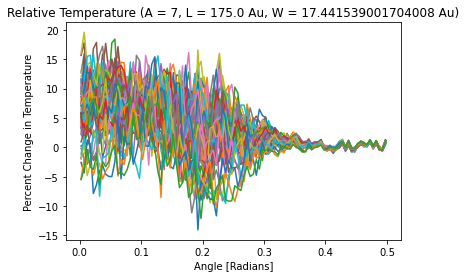

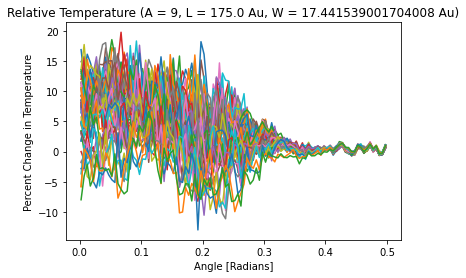

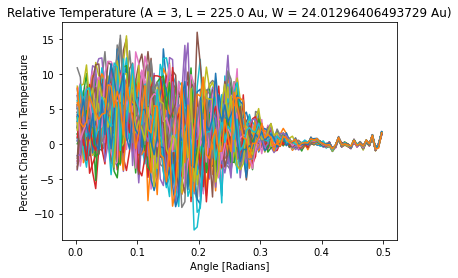

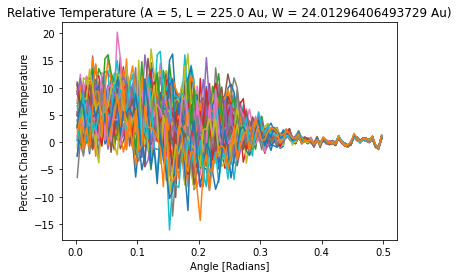

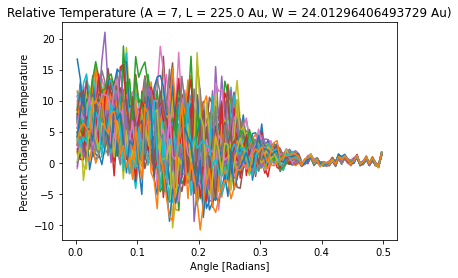

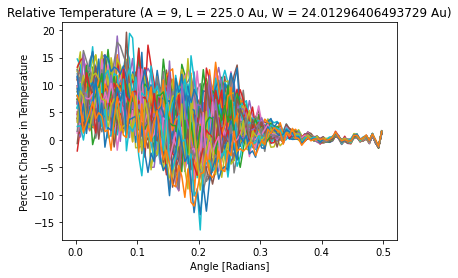

In [462]:
from scipy.optimize import curve_fit
amp_initial, amp_final, loc_initial, loc_final, a_step, l_step = 3, 11, 25*au, 275*au, 2, 50*au
T_max = np.empty((int((loc_final - loc_initial) / l_step), int((amp_final - amp_initial) / a_step)))
for i in range(0, int((loc_final - loc_initial) / l_step)):
    for j in range(0, int((amp_final - amp_initial) / a_step)):
        x = data.grid.x/natconst.au
        l = i*l_step + loc_initial
        a = j*a_step + amp_initial
        #Append only unique amplitude and location values 
        if a not in amp_arr:
            amp_arr = np.append(amp_arr, a)
        else:
            pass
        if l not in loc_arr:
            loc_arr = np.append(loc_arr, l)
        else: 
            pass
        #The index of x which corresponds to the value in x closest to the location of the perturbation
        l_index = np.abs(x - (l / au)).argmin()
        width = hp[l_index]
        #Create a loop to find an equally spaced interval on either side of the temperature variation maximum
        for backward in range(1, l_index): 
            if abs(x[int(T_max_index[i][j])] - x[int(T_max_index[i][j]) - backward]) <= 3: 
                pass
            else:
                B = backward
                break

        for forward in range(1, len(X) - l_index):
            if abs(x[int(T_max_index[i][j])] - x[int(T_max_index[i][j]) + forward]) <= 3:
                pass
            else:
                F = forward
                break
        
        fig, ax = plt.subplots()
        ax.set_title('Relative Temperature (A = '+str(j*a_step + amp_initial)+', L = '+str(l/au)+' Au, W = '+str(hp[l_index] / au)+' Au)')
        ax.set_xlabel('Angle [Radians]')
        ax.set_ylabel('Percent Change in Temperature')
        #ax.set_ylim(-25, 25)
        
        for k in range((int(T_max_index[i][j]) - B), (int(T_max_index[i][j]) + F)):
            ax.plot(np.pi/2.-data.grid.y, 100*(np.transpose(np.transpose(temp_list[i][j])[k]) - np.transpose(np.transpose(NoPertTemp)[k])) / np.transpose(np.transpose(NoPertTemp)[k]))
        
        #T_mean = sum(T_for_mean) / len(T_for_mean)
        
        #ax.set_xlim((l - 3*width) / au, (l + 3*width) / au)
        #ax.plot(x, T_mean)

In [456]:
print((l_index - B), (l_index + F))

940 1058


In [451]:
print(np.shape(temp_list))

(5, 4, 100, 1036)


In [ ]:
#We would like to know the angle at which the temperature variation is a maximum
#as a function of perturbation amplitude and location
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_title('Parameter Search Plot')
ax.set_xlabel('Perturbation Amplitude')
ax.set_ylabel('Perturbation Location [AU]')
ax.set_zlabel('Temperature Variation Maximum [K]')

X, Y = np.meshgrid(amp_arr, loc_arr / au)
Z = 
ax.plot_surface(X, Y, Z, rcount = 100, ccount = 100, edgecolor = 'none', cmap = cm.coolwarm)
ax.view_init(20,135)
plt.show()

In [ ]:
#
# Make sure to have done the following beforhand:
#
#  First compile RADMC-3D
#  Then run:
#   python problem_setup.py
#   radmc3d mctherm
#

dpc = 140.     # Distance in parsec (for conversion to Jy/pixel in 1.3 mm map)

#
# Make and plot image of full disk at 1.3 mm: thermal dust emission
#
makeImage(npix=200,incl=60.,phi=30.,wav=1.0e3,sizeau=200)   # This calls radmc3d 
im_mmPrePert1 = readImage()
plt.figure()
plotImage(im_mmPrePert1,au=True,log=True,maxlog=3,bunit='jy/pixel',dpc=dpc,cmap='magma')
plt.show()

    
#
# Make and plot image of full disk at 1 microns: scattered light
#
makeImage(npix=200,incl=60.,phi=30.,wav=10,sizeau=200)   # This calls radmc3d 
im_1PrePert2 = readImage()
plt.figure()
plotImage(im_1PrePert2,au=True,log=True,vmax=-10,vmin=-15,bunit='inu',cmap='hot')
plt.show()